In [3]:
import pandas as pd

df = pd.read_excel('a_b test ecom.xlsx', sheet_name='ab_test 2')
print('Размер загруженных данных:', df.shape[0])

Размер загруженных данных: 294478


In [4]:
#убираем пользователей, которые есть и в контрольной, и в тестовой группе
control = df[df['con_treat'] == 'control']
treatment = df[df['con_treat'] == 'treatment']
common_ids = treatment[treatment['id'].isin(control['id'])]['id']
result = df[df['id'].isin(common_ids)]
print('Количество ошибок в данных:', result.shape[0])

df = df.drop(df[df['id'].isin(common_ids)].index)
print('Количество строк после удаления ошибок:', df.shape[0])

Количество ошибок в данных: 3790
Количество строк после удаления ошибок: 290688


In [5]:
#группировка данных по количеству уникальных пользователей по группам
dfg = df.groupby(['id', 'con_treat']).size().reset_index(name='counts')
print('Размер сгруппированного датафрейма:', dfg.shape[0])

Размер сгруппированного датафрейма: 288689


In [6]:
# разделение данных на две группы
control = dfg[dfg['con_treat'] == 'control']
print("Размер выборки контрольной группы: ", len(control))

treatment = dfg[dfg['con_treat'] == 'treatment']
print("Размер выборки тестовой группы : ", len(treatment))

Размер выборки контрольной группы:  144300
Размер выборки тестовой группы :  144389


In [39]:
# Найдем просмотренных страниц в группах
df_count = dfg.groupby('counts')['con_treat'].value_counts().reset_index(name='totals')
df_count['totals %'] = df_count.totals.apply(lambda x: x/dfg.shape[0]*100)
df_count

,counts,con_treat,totals,totals %
0,1,treatment,143397,49.671792
1,1,control,143293,49.635767
2,2,control,1007,0.348818
3,2,treatment,992,0.343622


In [26]:
# Creating the sampling distribution of difference in means 
means_diff = []
size = df.shape[0]
for _ in range(5000):
    sample = dfg.sample(size, replace = True)
    control_mean = sample[sample["con_treat"] == "control"]["counts"].mean()
    treat_mean = sample[sample["con_treat"] == "treatment"]["counts"].mean()
    means_diff.append(treat_mean - control_mean)

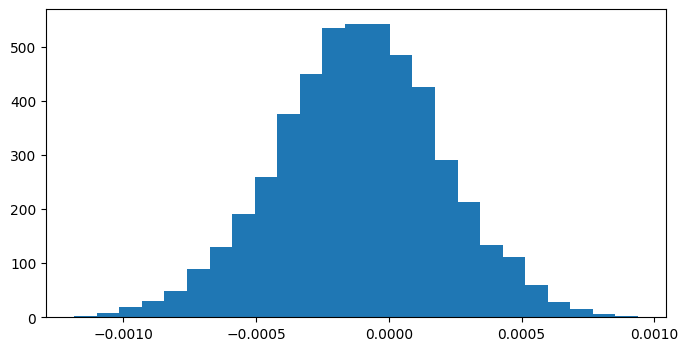

In [27]:
# Plotting the sampling distribution 
import matplotlib.pyplot as plt # basic visualizations 
plt.figure(figsize = (8,4), dpi = 100)
plt.hist(means_diff, bins = 25)
plt.show()

In [28]:
import numpy as np

# Simulate distribution under the null hypothesis
means_diff = np.array(means_diff)
null_vals = np.random.normal(0, means_diff.std(), means_diff.size)

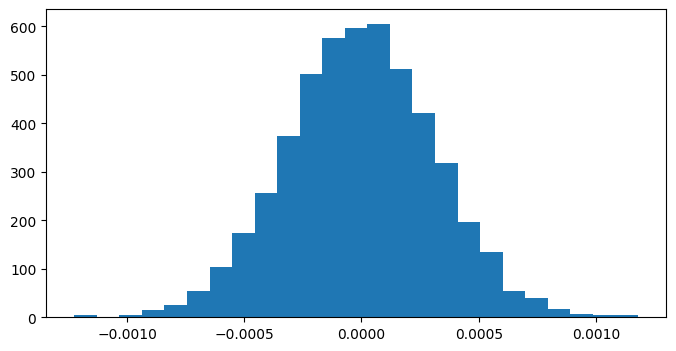

In [29]:
# Plot the null distribution
plt.figure(figsize = (8,4), dpi = 100)
plt.hist(null_vals, bins = 25)
plt.show()

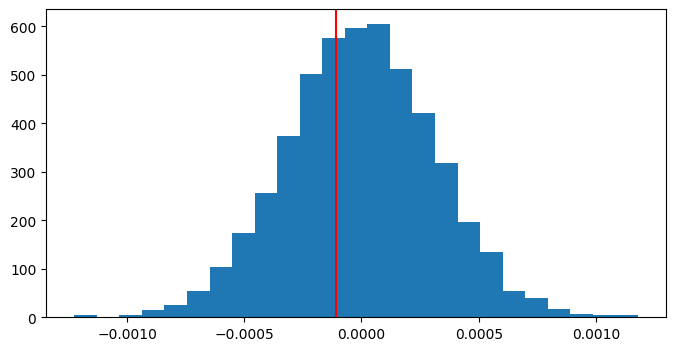

In [30]:
# Plot observed statistic with the null distibution
control_mean = control["counts"].mean()
treatment_mean = treatment["counts"].mean()
obs_diff = treatment_mean - control_mean

plt.figure(figsize = (8,4), dpi = 100)
plt.hist(null_vals, bins = 25)
plt.axvline(obs_diff, c='red')
plt.show()

In [31]:
# calculating the p value 
(null_vals > obs_diff).mean()

0.6252

Значение p-value (0,652) больше уровня значимости alpha, поэтому мы не отвергаем нулевую гипотезу. Это подтверждает наше начальное заключение о том, что количество визитов на уникального пользователя не зависит от группы.

In [40]:
dfg.groupby('con_treat')['counts'].describe()

,count,mean,std,min,25%,50%,75%,max
con_treat,,,,,,,,
control,144300.0,1.006979,0.083246,1.0,1.0,1.0,1.0,2.0
treatment,144389.0,1.006870,0.082603,1.0,1.0,1.0,1.0,2.0


In [46]:
from scipy.stats import ttest_ind

ttest_ind(treatment['counts'], control['counts'], alternative='greater')

Ttest_indResult(statistic=-0.3504922563348804, pvalue=0.6370152218315992)